# Прогноз ухода клиента для "Бета-Банка"

## Общие сведения о проекте

* Целью проекта является модель, способная спрогозировать уход клиента из банка в ближайшее время, для предотвращения их ухода (привлекать новых клиентов дороже, чем сохранить текущих).
* Исходно даны исторические данные о поведении клиентов и расторжении договоров с банком.
* Необходимое значение F1-меры > 0.59.
* Дополнительно стоит измерять AUC-ROC, сравнивайте её значение с F1-мерой.

### План:

* Получение данных и изучение общей информации о них.
* Предробработка данных.
* Исследование баланса классов, обучение модели без учета дисбаланса.
* Улучшиние качества модели, учитывая дисбаланс классов.
* Обучиние разных моделей и поиск лучшей.
* Финальное тестирование.
* Проверка модели на вменяемость.

## Подключение библиотек и инициализация констант

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, matthews_corrcoef
from sklearn.utils import shuffle

In [2]:
random_state = 12345

## Загрузка и предобработка данных

### Загрузка данных

In [3]:
try: 
    data = pd.read_csv('../../datasets/Churn.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
data = data.drop('RowNumber', axis=1)
data.head(15)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Сразу убрана избыточная колонка RowNumber, которая не несет в себе никакой полезкой информации.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1015.8+ KB


In [5]:
data.shape

(10000, 13)

In [6]:
# Проверяем количество пропусков в %
data.isnull().sum()*100/len(data)

CustomerId         0.00
Surname            0.00
CreditScore        0.00
Geography          0.00
Gender             0.00
Age                0.00
Tenure             9.09
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.00
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64

### Предобработка данных

In [7]:
data.columns = ['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']

Названия колонок приведены к нижнему регистру.

In [8]:
data['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [9]:
data['tenure'].isna().sum()

909

In [10]:
data[data['tenure'].isna()].head(20)

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


* Есть пропуски в колонке tenure, причиной их появления может служить технический сбой при парсинге данных или заполнение нулей таким образом.
* Для обучения моделей эти пропуски необходимо запонить или избавиться от строк, которые их содержат.
* Заполним пропуски нулями (пропуски составляют примерно 9% данных и отказываться от них не хочется, заполнение медианой, средним или модой может ухудшить предсказания моделей).

In [11]:
data['tenure'] = data['tenure'].fillna(0)

In [12]:
# Проверка на явные дубликаты
data.duplicated().sum()

0

In [13]:
data['tenure'] = data['tenure'].astype('int16')

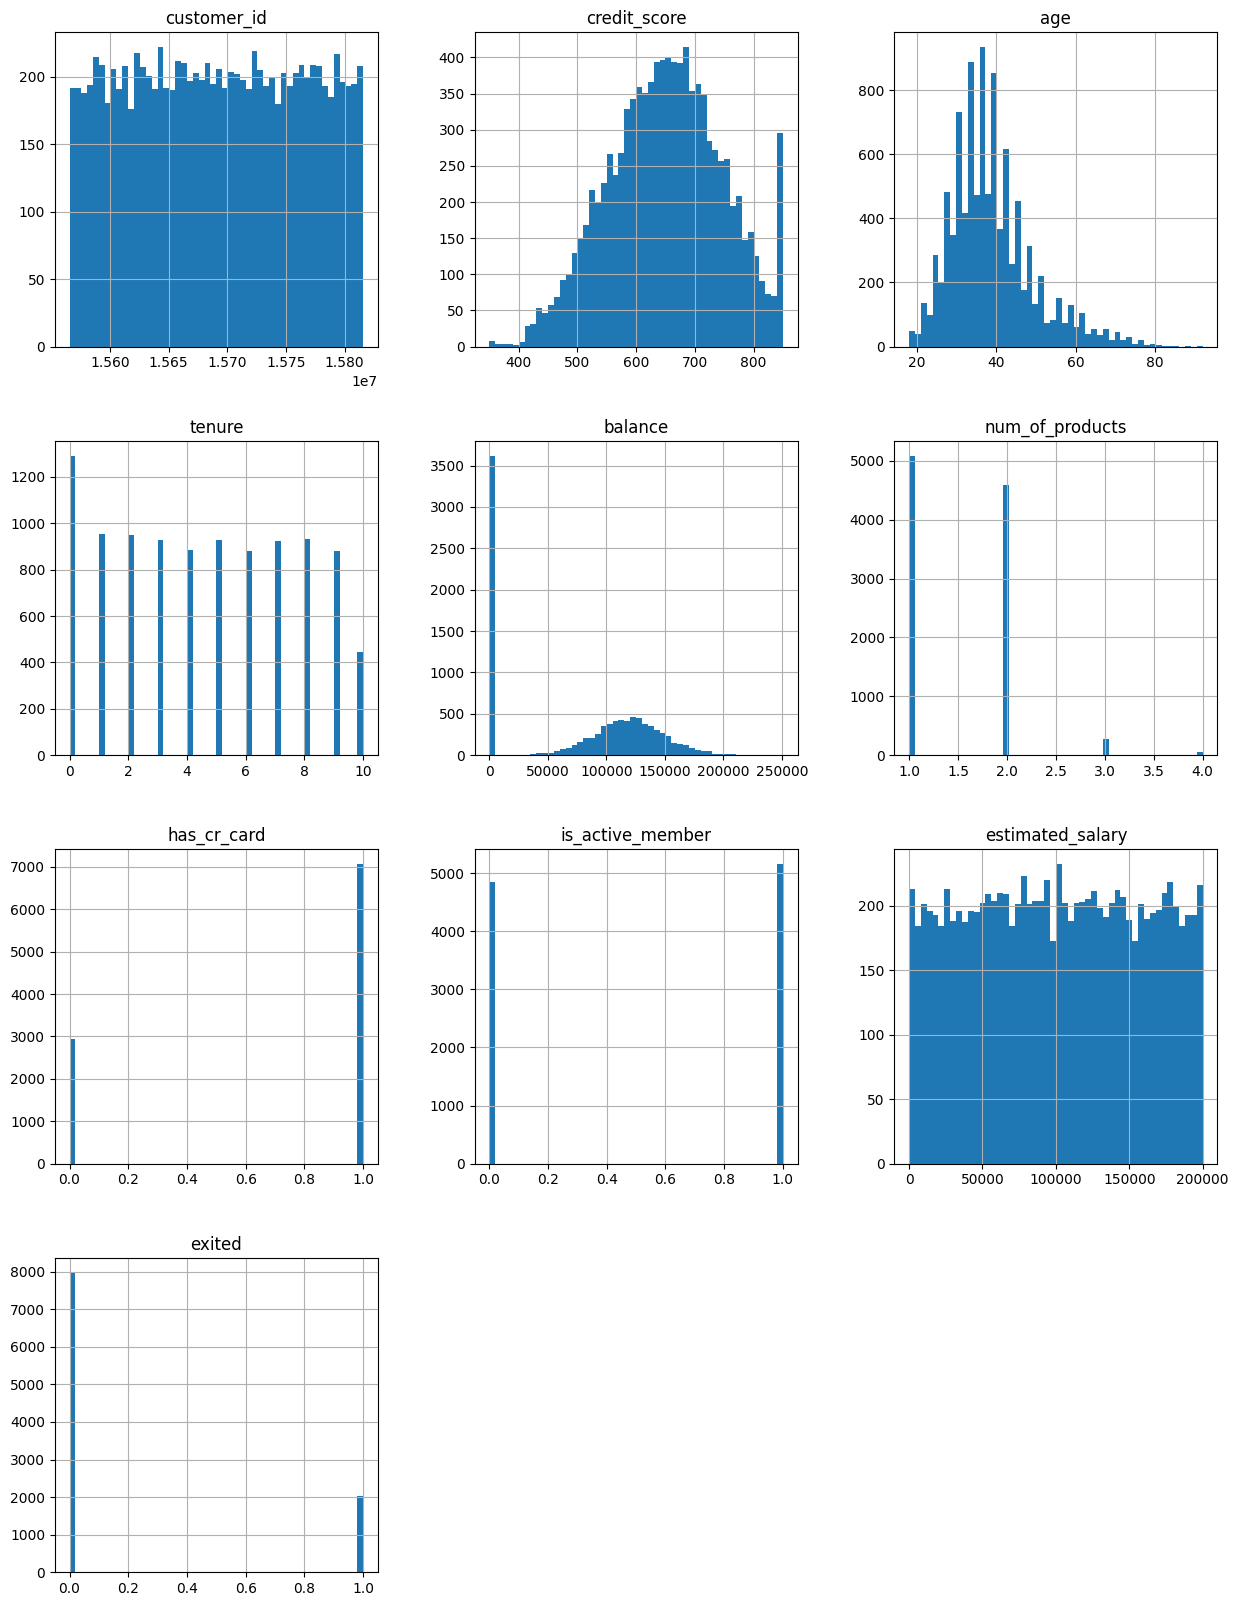

In [14]:
data.hist(figsize=(15, 20), bins=50);

### Вывод по разделу 

* Мы имеем 10 000 обьектов и 12 признаков для каждого.
* Названия колонок приведены к нижнему регистру.
* Колонка tenure содержит примерно 9% пропусков, которые заполнены нулями.
* Дубликатов в данных не найдено.
* Тип данных в колонке tenure приведен к целочисленному для экономии памяти.

## Исследование баланса классов и обучение моделей без учете дисбаланса классов.

### Дисбаланс классов

In [15]:
data['exited'].value_counts()*100/len(data)

0    79.63
1    20.37
Name: exited, dtype: float64

Классы несбалансированы, ушедших примерно в 4 раза меньше чем оставшихся.

### Подготавливаем данные к обучению

In [16]:
# Создаем новый датасет из исходного без колоной не влияющих на обучение
data_train = data.drop(['customer_id', 'surname', 'geography'], axis=1)

In [17]:
# Переводим категориальные переменные в численные
data_train = pd.get_dummies(data_train, drop_first=True)
display(data_train.shape)
data_train.head()

(10000, 10)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0


In [18]:
# Разбиваем выборку на обучающаю валидационную и тестовую
features = data_train.drop('exited', axis=1)
target = data_train['exited']
# Сначала разделим на выборки для обучения и валидационную и тестовую(в одной выборке) 
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.4, random_state=12345)
# Разделим получившуюся выборку для проверки на валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=.5, random_state=12345)

In [19]:
display(features_train.count())
display(features_valid.count())
features_test.count()

credit_score        6000
age                 6000
tenure              6000
balance             6000
num_of_products     6000
has_cr_card         6000
is_active_member    6000
estimated_salary    6000
gender_Male         6000
dtype: int64

credit_score        2000
age                 2000
tenure              2000
balance             2000
num_of_products     2000
has_cr_card         2000
is_active_member    2000
estimated_salary    2000
gender_Male         2000
dtype: int64

credit_score        2000
age                 2000
tenure              2000
balance             2000
num_of_products     2000
has_cr_card         2000
is_active_member    2000
estimated_salary    2000
gender_Male         2000
dtype: int64

Данные разделены в соотношении 3:1:1 на тренировочную, валидационную и тестовую выборки соответственно. 

### Проводим обучение на разным моделях, подбирая гоперпараметры, и смотрим как справляются модели 

#### Логистическая регрессия

In [20]:
logistic_regression = LogisticRegression(random_state=random_state,  solver='liblinear')
logistic_regression.fit(features_train, target_train)

result = logistic_regression.score(features_valid, target_valid)
display("accuracy модели на валидационной выборке:", result)

predicted_valid = logistic_regression.predict(features_valid)
display("F1-мера на валидационной выборке:", f1_score(target_valid, predicted_valid))

probabilities_valid = logistic_regression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

'accuracy модели на валидационной выборке:'

0.782

'F1-мера на валидационной выборке:'

0.08403361344537813

'AUC-ROC на валидационной выборке:'

0.6726994477343802

Логистическая регрессия показывает accuracy даже меньше чем показала бы DummyClassifier, F1-мера также имеет очень низкое значение.

#### Дерево решений

In [21]:
best_model = None
best_result = -200
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

display("accuracy наилучшей модели на валидационной выборке:", best_model.score(features_valid, target_valid), "Глубина дерева:", best_depth)

predicted_valid = best_model.predict(features_valid)
display("F1-мера на валидационной выборке:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

'accuracy наилучшей модели на валидационной выборке:'

0.852

'Глубина дерева:'

4

'F1-мера на валидационной выборке:'

0.5528700906344411

'AUC-ROC на валидационной выборке:'

0.8203012055480615

Дерево решений в целом уже лучше справляется со своей задачей: F1-мера примерно равна 0.54, accuracy=0.852, AUC-ROC=0.82, что говорит о том что модель справляется со своей задачей лучше чем случайная.

#### Случайный лес

In [22]:
best_model = None
best_result = -200
best_est = 0
best_depth = 0
for est in range(10, 71, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

display("accuracy наилучшей модели на валидационной выборке:", best_model.score(features_valid, target_valid), "Глубина дерева:", best_depth, "Количество деревьев:", best_est)

predicted_valid = best_model.predict(features_valid) 
display("F1-мера на валидационной выборке:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

'accuracy наилучшей модели на валидационной выборке:'

0.858

'Глубина дерева:'

10

'Количество деревьев:'

20

'F1-мера на валидационной выборке:'

0.5617283950617283

'AUC-ROC на валидационной выборке:'

0.842304121123404

Случайный лес справляется лучше чем остальные модели (F1-мера примерно равна 0.56, accuracy=0.858, AUC-ROC=0.84), но обучается заметно дольше чем дерево решений с похожим результатом.

### Вывод по разделу

* Логистическая регрессия показывает accuracy даже меньше чем показала бы DummyClassifier, F1-мера также имеет очень низкое значение.
* Дерево решений в целом уже лучше справляется со своей задачей: F1-мера примерно равна 0.54, accuracy=0.852, AUC-ROC=0.82, что говорит о том что модель справляется со своей задачей лучше чем случайная.
* Случайный лес справляется лучше чем остальные модели (F1-мера примерно равна 0.56, accuracy=0.858, AUC-ROC=0.84), но обучается заметно дольше чем дерево решений с похожим результатом.

## Улучшение качества модели посредством обработки дисбаланса классов.

### Взвешивание классов

#### Логистическая регрессия

In [23]:
logistic_regression = LogisticRegression(random_state=random_state, solver='liblinear', class_weight='balanced')
logistic_regression.fit(features_train, target_train)

result = logistic_regression.score(features_valid, target_valid)
display("accuracy модели на валидационной выборке:", result)

predicted_valid = logistic_regression.predict(features_valid)
display("F1-мера на валидационной выборке:", f1_score(target_valid, predicted_valid))

probabilities_valid = logistic_regression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

'accuracy модели на валидационной выборке:'

0.681

'F1-мера на валидационной выборке:'

0.4787581699346405

'AUC-ROC на валидационной выборке:'

0.7457264440263975

#### Дерево решений

In [24]:
best_model = None
best_result = -200
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

display("accuracy наилучшей модели на валидационной выборке:", best_model.score(features_valid, target_valid), "Глубина дерева:", best_depth)

predicted_valid = best_model.predict(features_valid)
display("F1-мера на валидационной выборке:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

'accuracy наилучшей модели на валидационной выборке:'

0.8085

'Глубина дерева:'

5

'F1-мера на валидационной выборке:'

0.5894962486602359

'AUC-ROC на валидационной выборке:'

0.8197447056902112

#### Случайный лес

In [25]:
best_model = None
best_result = -200
best_est = 0
best_depth = 0
for est in range(10, 71, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

display("accuracy наилучшей модели на валидационной выборке:", best_model.score(features_valid, target_valid), "Глубина дерева:", best_depth, "Количество деревьев:", best_est)

predicted_valid = best_model.predict(features_valid) 
display("F1-мера на валидационной выборке:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

'accuracy наилучшей модели на валидационной выборке:'

0.816

'Глубина дерева:'

7

'Количество деревьев:'

60

'F1-мера на валидационной выборке:'

0.615866388308977

'AUC-ROC на валидационной выборке:'

0.8487227723371179

### Увеличение выборки

In [26]:
# Функция для увеличения выборки копированием положительных обьектов
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [27]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

#### Логистическая регрессия

In [28]:
logistic_regression = LogisticRegression(random_state=random_state)
logistic_regression.fit(features_upsampled, target_upsampled)

result = logistic_regression.score(features_valid, target_valid)
display("accuracy модели на валидационной выборке:", result)

predicted_valid = logistic_regression.predict(features_valid)
display("F1-мера на валидационной выборке:", f1_score(target_valid, predicted_valid))

probabilities_valid = logistic_regression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

'accuracy модели на валидационной выборке:'

0.6535

'F1-мера на валидационной выборке:'

0.44692737430167606

'AUC-ROC на валидационной выборке:'

0.7130698830745407

#### Дерево решений

In [29]:
best_model = None
best_result = -200
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

display("accuracy наилучшей модели на валидационной выборке:", best_model.score(features_valid, target_valid), "Глубина дерева:", best_depth)

predicted_valid = best_model.predict(features_valid)
display("F1-мера на валидационной выборке:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

'accuracy наилучшей модели на валидационной выборке:'

0.8085

'Глубина дерева:'

5

'F1-мера на валидационной выборке:'

0.5894962486602359

'AUC-ROC на валидационной выборке:'

0.8197447056902112

#### Случайный лес

In [30]:
best_model = None
best_result = -200
best_est = 0
best_depth = 0
for est in range(10, 71, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

display("accuracy наилучшей модели на валидационной выборке:", best_model.score(features_valid, target_valid), "Глубина дерева:", best_depth, "Количество деревьев:", best_est)

predicted_valid = best_model.predict(features_valid) 
display("F1-мера на валидационной выборке:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

'accuracy наилучшей модели на валидационной выборке:'

0.8085

'Глубина дерева:'

8

'Количество деревьев:'

70

'F1-мера на валидационной выборке:'

0.6079836233367452

'AUC-ROC на валидационной выборке:'

0.8457361222847948

### Уменьшение выборки

In [31]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [32]:
features_downsampled, target_downsampled = downsample(features_train, target_train, .25)

#### Логистическая регрессия

In [33]:
logistic_regression = LogisticRegression(random_state=random_state)
logistic_regression.fit(features_downsampled, target_downsampled)

result = logistic_regression.score(features_valid, target_valid)
display("accuracy модели на валидационной выборке:", result)

predicted_valid = logistic_regression.predict(features_valid)
display("F1-мера на валидационной выборке:", f1_score(target_valid, predicted_valid))

probabilities_valid = logistic_regression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

'accuracy модели на валидационной выборке:'

0.6505

'F1-мера на валидационной выборке:'

0.4474308300395257

'AUC-ROC на валидационной выборке:'

0.7118086850271295

#### Дерево решений

In [34]:
best_model = None
best_result = -200
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

display("accuracy наилучшей модели на валидационной выборке:", best_model.score(features_valid, target_valid), "Глубина дерева:", best_depth)

predicted_valid = best_model.predict(features_valid)
display("F1-мера на валидационной выборке:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

'accuracy наилучшей модели на валидационной выборке:'

0.768

'Глубина дерева:'

3

'F1-мера на валидационной выборке:'

0.5555555555555556

'AUC-ROC на валидационной выборке:'

0.8027820456208905

#### Случайный лес

In [35]:
best_model = None
best_result = -200
best_est = 0
best_depth = 0
for est in range(10, 71, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

display("accuracy наилучшей модели на валидационной выборке:", best_model.score(features_valid, target_valid), "Глубина дерева:", best_depth, "Количество деревьев:", best_est)

predicted_valid = best_model.predict(features_valid) 
display("F1-мера на валидационной выборке:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("AUC-ROC на валидационной выборке:", roc_auc_score(target_valid, probabilities_one_valid))

'accuracy наилучшей модели на валидационной выборке:'

0.793

'Глубина дерева:'

7

'Количество деревьев:'

70

'F1-мера на валидационной выборке:'

0.6019230769230769

'AUC-ROC на валидационной выборке:'

0.8429626963627895

### Вывод по разделу

* Логистическая регрессия показывает недостаточные результаты при обучении без учета дисбаланса классов, с балансировкой классов, уменьшении и увеличении выборки.
* Дерево решений показывает лучшие результаты при взвешивании и увеличении выборки, но показатель F1-меры недотягивает до нужного результата.
* Случайный лес показывает удовлитровительный результат при увеличении, уменьшении и взвешивании выборки F1-меры при этих подходах равны соответственно: 0.61, 0.6 и 0.62.

## Финальное тестирование и выбор лучшей модели.

### Подготовка моделей

In [36]:
# Воссоздаем лучшие модели
model_balansed = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=7, class_weight='balanced')
model_upsampled = RandomForestClassifier(random_state=12345, n_estimators=70, max_depth=8)
model_downsampled = RandomForestClassifier(random_state=12345, n_estimators=70, max_depth=7)

In [37]:
# Обучение моделей
model_balansed.fit(features_train, target_train)
model_upsampled.fit(features_upsampled, target_upsampled)
model_downsampled.fit(features_downsampled, target_downsampled)

RandomForestClassifier(max_depth=7, n_estimators=70, random_state=12345)

### Результат при взвешивании классов

In [38]:
display("accuracy случайного леса с взвешиванием классов на тестовой выборке:", model_balansed.score(features_test, target_test))

predicted_test = model_balansed.predict(features_test) 
display("F1-мера на тестовой выборке:", f1_score(target_test, predicted_test))

probabilities_test = model_balansed.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
display("AUC-ROC на тестовой выборке:", roc_auc_score(target_test, probabilities_one_test))

'accuracy случайного леса с взвешиванием классов на тестовой выборке:'

0.812

'F1-мера на тестовой выборке:'

0.6033755274261604

'AUC-ROC на тестовой выборке:'

0.8424740394950463

### Результат при уменьшении выборки

In [39]:
display("accuracy случайного леса с уменьшением выборки на тестовой выборке:", model_downsampled.score(features_test, target_test))

predicted_test = model_downsampled.predict(features_test) 
display("F1-мера на тестовой выборке:", f1_score(target_test, predicted_test))

probabilities_test = model_downsampled.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
display("AUC-ROC на тестовой выборке:", roc_auc_score(target_test, probabilities_one_test))

'accuracy случайного леса с уменьшением выборки на тестовой выборке:'

0.7735

'F1-мера на тестовой выборке:'

0.5746478873239437

'AUC-ROC на тестовой выборке:'

0.8381851407121579

### Результат при увеличении выборки

In [40]:
display("accuracy случайного леса с увеличением выборки на тестовой выборке:", model_upsampled.score(features_test, target_test))

predicted_test = model_upsampled.predict(features_test) 
display("F1-мера на тестовой выборке:", f1_score(target_test, predicted_test))

probabilities_test = model_upsampled.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
display("AUC-ROC на тестовой выборке:", roc_auc_score(target_test, probabilities_one_test))

'accuracy случайного леса с увеличением выборки на тестовой выборке:'

0.799

'F1-мера на тестовой выборке:'

0.5872689938398357

'AUC-ROC на тестовой выборке:'

0.8400020387634899

### Вывод по разделу

По итогам тестирования удовлетворяет требованиям только слечайный лес с взвешиванием классов (Accuracy = 0.812, F1-мера = 0.6, AUC-ROC = 0.84).

## Дополнительная проверка модели

In [41]:
predicted_test = model_balansed.predict(features_test) 
display(recall_score(target_test, predicted_test), 
        precision_score(target_test, predicted_test), 
        matthews_corrcoef(target_test, predicted_test))

0.6761229314420804

0.5447619047619048

0.4868702960597257

## Общий вывод

### Предобработка данных:

* Данные имеют следующий вид: 10000 обьектов и 12 признаков из них только 9 имеют значение при обучении модели.
* Колонка tenure содержит примерно 9% пропусков, которые заполнены нулями.
* Дубликатов в данных не найдено.

### Обучение моделей и исследование их качества:

* Исходные данные были разделены на обучающие, валидационные и тестовые выборки в соотношении 3:1:1
* Классы несбалансированы, ушедших примерно в 4 раза меньше чем оставшихся.

#### Обучение без учета дисбаланса классов:

* Логистическая регрессия показывает accuracy даже меньше чем показала бы DummyClassifier, F1-мера также имеет очень низкое значение.
* Дерево решений в целом уже лучше справляется со своей задачей: F1-мера примерно равна 0.54, accuracy=0.852, AUC-ROC=0.82, что говорит о том что модель справляется со своей задачей лучше чем случайная.
* Случайный лес справляется лучше чем остальные модели (F1-мера примерно равна 0.56, accuracy=0.858, AUC-ROC=0.84), но обучается заметно дольше чем дерево решений с похожим результатом.
* Ни одна из моделей не удовлетворяет условию F1-мера >= 0.59.

#### Обработка дисбаланса классов:

* Логистическая регрессия показывает недостаточные результаты при обучении без учета дисбаланса классов, с балансировкой классов, уменьшении и увеличении выборки.
* Дерево решений показывает лучшие результаты при взвешивании и увеличении выборки, но показатель F1-меры недотягивает до нужного результата.
* Случайный лес показывает удовлитровительный результат при увеличении, уменьшении и взвешивании выборки F1-меры при этих подходах равны соответственно: 0.61, 0.6 и 0.62.
* По итогам обработки дисбаланса классов условию удовлетворяют 3 модели случайного леса: 
    * случайный лес с взвешиваением классов, количеством деревьев = 60 и максимальной глубиной = 7,
    * случайный лес с уменьшением выборки, количеством деревьев = 70 и максимальной глубиной = 7,
    * случайный лес с увеличением выборки, количеством деревьев = 70 и максимальной глубиной = 8,

#### Финальное тестирование моделей:

* По итогам тестирования удовлетворяет требованиям только слечайный лес с взвешиванием классов (Accuracy = 0.812, F1-мера = 0.6, AUC-ROC = 0.84).

### Рекомендации:

* Стоит учитывать, что метрики accuracy, F1-мера и AUC-ROC могут быть чувствительны к дисбалансу классов.
* Дополнительная проверка модели показала, что лучшая модель имеет долю истинноположительных примеров равную примерно 0.55, а долю истинноположительных классификаций к общему числу положительных классификаций 0.68, хотя метрика AUC-ROC показывает вполне хорошие результаты.
* Также Коэффициент Мэтьюса, учитывающий все типы результатов корреляции показал неплохой результат = 0.49.
* Работу модели также можно сделать точнее избавившись от пропусков в колонке tenure и увеличив обьем исходных данных, возможно имеет смысл расширить ряд признаков.